In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date

from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

from lightgbm import LGBMClassifier
import preprocessing

In [3]:
#Import data
xtrain = pd.read_csv("Xtrain.csv")
ytrain = pd.read_csv("Ytrain.csv")
records = xtrain.copy()
records['ChargeOff'] = ytrain['ChargeOff']

In [4]:
processed_records = preprocessing.all_preprocess_with_label_encoding(records)

In [5]:
x = processed_records.drop(columns='ChargeOff')
y = processed_records['ChargeOff']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=0)

In [13]:
#Hyperparameter configs in LightGBM
boosting_type = ['gbdt', 'dart', 'goss']
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 120, num = 20)]
num_leaves = [int(x) for x in np.linspace(start = 70, stop = 150, num = 20)]
learning_rate=[.05, .07, .09, .1, .12]
max_depth = [5,6,-1]
# Create the random grid
random_grid = {'boosting_type':boosting_type,
               'n_estimators': n_estimators,
               'num_leaves': num_leaves,
               'learning_rate': learning_rate,
               'max_depth': max_depth, }
# Use the random grid to search for best hyperparameters
# First create the base model to tune
lgb = LGBMClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
lgb_random = RandomizedSearchCV(estimator = lgb, param_distributions = random_grid, n_iter = 100, cv = 10, verbose=2, random_state=51, n_jobs = -1)
lgb_random.fit(x_train, y_train)

print(lgb_random.best_params_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.9min finished


{'num_leaves': 103, 'n_estimators': 90, 'max_depth': -1, 'learning_rate': 0.1, 'boosting_type': 'goss'}


In [14]:
def evaluate(model, x_test, y_test):
    accuracy=accuracy_score(y_test, model.predict(x_test))
    print('Model Performance')
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    return accuracy

base_model = LGBMClassifier(random_state = 51)
base_model.fit(x_train, y_train)
base_accuracy = evaluate(base_model, x_test, y_test)

best_random = lgb_random.best_estimator_
random_accuracy = evaluate(best_random, x_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Accuracy = 0.93%.
Model Performance
Accuracy = 0.93%.
Improvement of 0.50%.


In [9]:
lgb.set_params(**lgb_random.best_params_)

LGBMClassifier(learning_rate=0.09, n_estimators=116, num_leaves=74)

In [15]:
lgb.fit(x_train,y_train)
accuracy=accuracy_score(y_test, lgb.predict(x_test))
accuracy

0.92656

<BarContainer object of 23 artists>

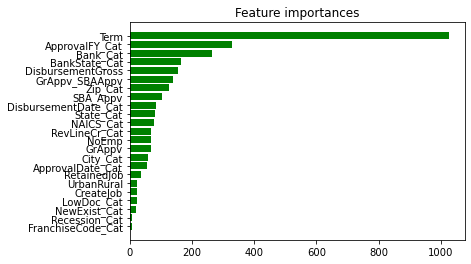

In [23]:
feature_import = list(zip(x_train.columns,lgb.feature_importances_))
df = pd.DataFrame(columns=['Feature', 'Importance'], data=feature_import)
df=df.sort_values(by=['Importance'])
plt.figure()
plt.title("Feature importances")
plt.barh(df['Feature'], df['Importance'],
       color="g", align="center", )

In [16]:
Xtest = pd.read_csv('Xtest.csv')
Xtest_processed = preprocessing.all_preprocess_with_label_encoding(Xtest)

/Users/shiyu/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [17]:
submission = pd.DataFrame()
submission['Id'] = Xtest['Id']
submission['ChargeOff'] = best_random.predict(Xtest_processed)
submission.to_csv('submission_lightgbm.csv', index=False)